In [1]:
%load_ext autoreload
%autoreload 2

# Introduction 

This notebook is the first architecture experiment. Modifications done:
1. remove the nn.embedding
2. added a dot product before final predictor layer

# Imports

In [2]:
import pandas as pd
import numpy as np
import torch

from utils.setup_nodes import create_edge_lists
from utils.graph_helpers import train_model, plot_train_val_loss, final_evaluation
from utils.graph_model import Experiment_1
from utils.general import seed_everything
from utils.predictions import recommend_products, pretty_print_recomendations, get_top_k_preds

# Set up

In [3]:
seed_everything()

In [4]:
user_split = "train_test_valid"
prod_embed_name = "meta_features_512"
user_embed_name = "user_reviews_features_512"

data_dir = "data"
product_dir = "full_data"
embedding_dir = "embedding"

device = "cuda"

product_cols = ["parent_asin", "average_rating", "rating_number"]
user_cols = ["user_id", "rating_mean", "rating_count", "helpful_vote_mean", "helpful_vote_gte_1", "verified_purchase_mean", "last_active_in_days_min",
            "last_active_in_days_max", "word_count_mean"]
edge_cols = ["user_id", "parent_asin", "rating"]

fill_users = "zero"

# Load data

In [5]:
product_df = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = product_cols)
train_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/train_agg.parquet", columns = user_cols)
train_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/train.parquet", columns = edge_cols)

if user_split == "train_test_valid":
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/valid_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/valid.parquet", columns = edge_cols)
else:
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/test_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/test.parquet", columns = edge_cols)


In [6]:
product_embedding = torch.load(f"{data_dir}/{embedding_dir}/product/{prod_embed_name}.pt")
train_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/train_{user_embed_name}.pt")
if user_split == "train_test_valid":
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/valid_{user_embed_name}.pt")
else:
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/test_{user_embed_name}.pt")

# Make nodes

In [7]:
# Add the embedding 
train_user_df["embedding"] = list(train_user_embedding.numpy())
test_user_df["embedding"] = list(test_user_embedding.numpy())

# Concat user nodes 
additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()

## these are users that need to be zero-ed out 
additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()
additional_test_users["embedding"] = list(torch.zeros((len(additional_test_users), test_user_embedding.shape[1])).numpy())
if fill_users == "zero":
    additional_test_users.iloc[:, 1:-1] = 0
elif fill_users == "mean":
    additional_test_users.iloc[:, 1:-1] = train_user_df.iloc[:, 1:].mean()

# Make super user df
user_df = pd.concat([train_user_df, additional_test_users])

In [8]:
# Set up id mapping
offset = user_df.user_id.nunique()
user_id_to_idx = {unique_id : idx for idx, unique_id in enumerate(user_df.user_id.unique())}
prod_id_to_idx = {unique_id : offset + idx for idx, unique_id in enumerate(product_df.parent_asin.unique())}

# Add to df
product_df["prod_idx"] = product_df.parent_asin.apply(lambda x: prod_id_to_idx[x])
train_user_edges["user_idx"] = train_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
test_user_edges["user_idx"] = test_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
train_user_edges["prod_idx"] = train_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])
test_user_edges["prod_idx"] = test_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])

In [9]:
# Concat product nodes 
product_nodes = torch.cat([torch.tensor(product_df.drop(["parent_asin", "prod_idx"], axis = 1).to_numpy()), product_embedding], dim = 1)

In [10]:
# concat user nodes 
user_embed = torch.tensor(np.vstack(user_df["embedding"].values))
user_info = torch.tensor(user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
user_nodes = torch.cat([user_info, user_embed], dim = 1)

In [11]:
# Create edge list
train_edge_index, train_edge_weights = create_edge_lists(train_user_edges)
test_edge_index, test_edge_weights = create_edge_lists(train_user_edges)

# Move to GPU 

In [12]:
product_nodes = product_nodes.type(torch.float).to(device)
user_nodes = user_nodes.type(torch.float).to(device)
train_edge_index = train_edge_index.to(device)
train_edge_weights = train_edge_weights.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_weights = test_edge_weights.to(device)

# Model

In [13]:
# Set up model features
num_users = len(user_df)
num_products = len(product_df)
user_feature_dim = user_nodes.shape[1]
product_feature_dim = product_nodes.shape[1]
embedding_dim = 64

In [14]:
# Instantiate the model
model = Experiment_1(num_users, num_products, user_feature_dim, product_feature_dim, embedding_dim)

In [15]:
# move the model 
model.to(device)

Experiment_1(
  (user_feature_transform): Linear(in_features=776, out_features=64, bias=True)
  (product_feature_transform): Linear(in_features=770, out_features=64, bias=True)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (predictor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

# Train

In [16]:
train_loss, test_loss, best_model = train_model(model, train_edge_index, train_edge_weights, test_edge_index, test_edge_weights, 
                                                 user_nodes, product_nodes, num_epochs = 1000, print_progress=True, print_freq=100)

Epoch: 100, Train Loss: 2.0337, Val Loss: 2.0296, best model epoch: 100
Epoch: 200, Train Loss: 0.9413, Val Loss: 0.8536, best model epoch: 200
Epoch: 300, Train Loss: 0.7784, Val Loss: 0.7622, best model epoch: 247
Epoch: 400, Train Loss: 0.5663, Val Loss: 0.5077, best model epoch: 400
Epoch: 500, Train Loss: 0.4850, Val Loss: 0.4433, best model epoch: 459
Epoch: 600, Train Loss: 0.5877, Val Loss: 0.4619, best model epoch: 564
Epoch: 700, Train Loss: 0.2738, Val Loss: 0.2477, best model epoch: 699
Epoch: 800, Train Loss: 0.2370, Val Loss: 0.2051, best model epoch: 798
Epoch: 900, Train Loss: 0.4803, Val Loss: 0.4098, best model epoch: 818
Epoch: 1000, Train Loss: 0.6023, Val Loss: 0.9411, best model epoch: 818


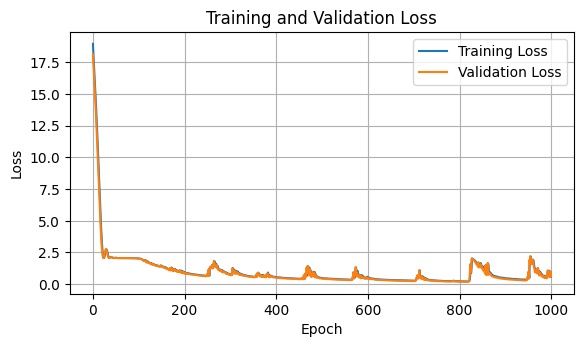

In [17]:
plot_train_val_loss(train_loss, test_loss)

# Test

Test loss: 0.1896


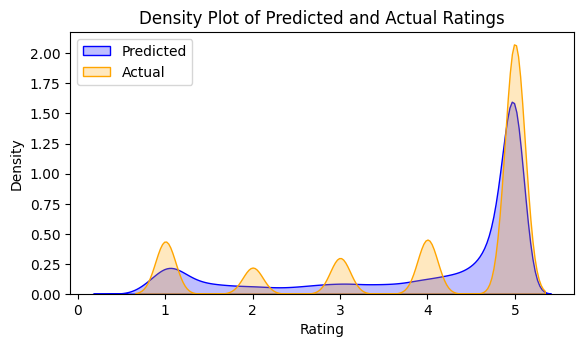

In [18]:
model.load_state_dict(best_model)
final_evaluation(model, test_edge_index, test_edge_weights, user_nodes, product_nodes, device, True)

# Metrics 

In [19]:
product_idx_tensor = torch.tensor(list(prod_id_to_idx.values()), dtype=torch.long, device = device)
test_edges_grp = test_user_edges.groupby("user_idx").prod_idx.apply(list).reset_index()
test_edges_users = test_edges_grp.user_idx.to_list()

In [20]:
predictions = get_top_k_preds(model, test_edges_users, 10, 32, user_nodes, product_nodes, product_idx_tensor, device) # about 5 min to run
test_edges_grp["prediction"] = list(torch.vstack(predictions).cpu().numpy())
test_edges_grp["match_count"] = test_edges_grp.apply(lambda x: len(set(x.prod_idx).intersection(set(x.prediction))), axis = 1)

In [21]:
# Overall recall
(test_edges_grp["match_count"] / test_edges_grp.prod_idx.apply(len)).mean()

np.float64(0.0)

In [22]:
# Only those with prior history 
existing_test_edges_grp = test_edges_grp[test_edges_grp.user_idx.isin(train_user_df.user_id.apply(lambda x: user_id_to_idx[x]))]
(existing_test_edges_grp["match_count"] / existing_test_edges_grp.prod_idx.apply(len)).mean()

np.float64(0.0)

In [23]:
test_edges_grp

,user_idx,prod_idx,prediction,match_count
0,52,[432992],"[11955, 44956, 71748, 29852, 85055, 59266, 156...",0
1,208,[415130],"[11955, 44956, 71748, 29852, 85055, 59266, 156...",0
2,269,[389583],"[11955, 44956, 71748, 29852, 85055, 59266, 156...",0
3,409,"[400190, 432224]","[11955, 44956, 71748, 29852, 85055, 59266, 156...",0
4,462,[413459],"[11955, 44956, 71748, 29852, 85055, 59266, 156...",0
...,...,...,...,...
97945,383698,[417796],"[44956, 11955, 29852, 38979, 85055, 71748, 592...",0
97946,383699,[472742],"[44956, 11955, 29852, 38979, 85055, 71748, 592...",0
97947,383700,[443441],"[44956, 11955, 29852, 38979, 85055, 71748, 592...",0
97948,383701,[436442],"[44956, 11955, 29852, 38979, 85055, 71748, 592...",0


In [24]:
preds = set(y.item() for x in test_edges_grp.prediction for y in x)
len(preds)

14

# Recomendations 

In [25]:
title_mapping = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = ["parent_asin", "title"])
prod_idx_to_id = {idx - offset: asin for asin, idx in prod_id_to_idx.items()}

In [42]:
# The pure random 
user_id = test_user_df.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: Atelier Cologne Mandarine Glaciale sample size vial 0.067 oz
Product 2: Micro USB Cable,Pashion 3ft Premium Micro USB Charging Cable High Speed USB 2.0 A Male to Micro B Charge Cables for Android
Product 3: 3 Pcs Xt60 Female to Male Ec5 Connector Adapter No Wires
Product 4: Werkryt MFi Certified iPhone Charger Lightning Cable 5 Pack [3/3/6/6/10FT] Extra Long Nylon Braided USB Charging & Syncing Cord Compatible iPhone Xs/Max/XR/X/8/8Plus/7/7Plus/6S/6S Plus/SE/iPad/Nan Mor
Product 5: RoseAndBlanc Nina's Paris Luxury Hand Soap Perfume Marie Antoinette Perfumed Apple Rose Bath Soap For Women Good Gift Idea 150G
Product 6: Dr fukuoka hourei Upper　Face exercise equipment Add to mouth
Product 7: 4pcs 1 pair 3 Magnet 3D Magnetic Eyelashes Magnet Lashes Thicker Reusable False Eyelashes Handmade No Glue Eye Lashes Makeup Kit
Product 8: Tara Girls Twin Flower Ponytail Holders - 8 Pcs.
Product 9: Titanic Stock Certificate
Product 10: Titanic Stock Certificate
tensor([4.1511, 4.1439, 4.1

In [27]:
# The user with some data 
existing_test_users = test_user_df[test_user_df.user_id.isin(train_user_df.user_id)].copy()[["user_id"]]

In [79]:
user_id = existing_test_users.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: Atelier Cologne Mandarine Glaciale sample size vial 0.067 oz
Product 2: Micro USB Cable,Pashion 3ft Premium Micro USB Charging Cable High Speed USB 2.0 A Male to Micro B Charge Cables for Android
Product 3: 3 Pcs Xt60 Female to Male Ec5 Connector Adapter No Wires
Product 4: RoseAndBlanc Nina's Paris Luxury Hand Soap Perfume Marie Antoinette Perfumed Apple Rose Bath Soap For Women Good Gift Idea 150G
Product 5: Werkryt MFi Certified iPhone Charger Lightning Cable 5 Pack [3/3/6/6/10FT] Extra Long Nylon Braided USB Charging & Syncing Cord Compatible iPhone Xs/Max/XR/X/8/8Plus/7/7Plus/6S/6S Plus/SE/iPad/Nan Mor
Product 6: Dr fukuoka hourei Upper　Face exercise equipment Add to mouth
Product 7: 4pcs 1 pair 3 Magnet 3D Magnetic Eyelashes Magnet Lashes Thicker Reusable False Eyelashes Handmade No Glue Eye Lashes Makeup Kit
Product 8: Tara Girls Twin Flower Ponytail Holders - 8 Pcs.
Product 9: Titanic Stock Certificate
Product 10: Titanic Stock Certificate
tensor([4.1560, 4.1488, 4.1

In [29]:
# The boosted way
# This is just to see if existing data (a bit of data leak) can help improve performance 
boosted_additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()
boosted_user_df = pd.concat([train_user_df, boosted_additional_test_users])
boosted_user_embed = torch.tensor(np.vstack(boosted_user_df["embedding"].values))
boosted_user_info = torch.tensor(boosted_user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
boosted_user_nodes = torch.cat([boosted_user_embed, boosted_user_info], dim = 1)

In [30]:
user_id = boosted_user_df.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: Atelier Cologne Mandarine Glaciale sample size vial 0.067 oz
Product 2: Micro USB Cable,Pashion 3ft Premium Micro USB Charging Cable High Speed USB 2.0 A Male to Micro B Charge Cables for Android
Product 3: 3 Pcs Xt60 Female to Male Ec5 Connector Adapter No Wires
Product 4: RoseAndBlanc Nina's Paris Luxury Hand Soap Perfume Marie Antoinette Perfumed Apple Rose Bath Soap For Women Good Gift Idea 150G
Product 5: Werkryt MFi Certified iPhone Charger Lightning Cable 5 Pack [3/3/6/6/10FT] Extra Long Nylon Braided USB Charging & Syncing Cord Compatible iPhone Xs/Max/XR/X/8/8Plus/7/7Plus/6S/6S Plus/SE/iPad/Nan Mor
Product 6: Dr fukuoka hourei Upper　Face exercise equipment Add to mouth
Product 7: 4pcs 1 pair 3 Magnet 3D Magnetic Eyelashes Magnet Lashes Thicker Reusable False Eyelashes Handmade No Glue Eye Lashes Makeup Kit
Product 8: Tara Girls Twin Flower Ponytail Holders - 8 Pcs.
Product 9: Titanic Stock Certificate
Product 10: Titanic Stock Certificate


In [31]:
# count more than 10 purchases
min_unique_purchase = 10
item_count_df = test_user_edges.groupby("user_id").prod_idx.apply(lambda x: len(set(x))).reset_index()
dense_user_id = item_count_df[item_count_df["prod_idx"] >= min_unique_purchase][["user_id"]]

In [87]:
user_id = dense_user_id.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: Atelier Cologne Mandarine Glaciale sample size vial 0.067 oz
Product 2: Micro USB Cable,Pashion 3ft Premium Micro USB Charging Cable High Speed USB 2.0 A Male to Micro B Charge Cables for Android
Product 3: 3 Pcs Xt60 Female to Male Ec5 Connector Adapter No Wires
Product 4: Werkryt MFi Certified iPhone Charger Lightning Cable 5 Pack [3/3/6/6/10FT] Extra Long Nylon Braided USB Charging & Syncing Cord Compatible iPhone Xs/Max/XR/X/8/8Plus/7/7Plus/6S/6S Plus/SE/iPad/Nan Mor
Product 5: RoseAndBlanc Nina's Paris Luxury Hand Soap Perfume Marie Antoinette Perfumed Apple Rose Bath Soap For Women Good Gift Idea 150G
Product 6: Dr fukuoka hourei Upper　Face exercise equipment Add to mouth
Product 7: 4pcs 1 pair 3 Magnet 3D Magnetic Eyelashes Magnet Lashes Thicker Reusable False Eyelashes Handmade No Glue Eye Lashes Makeup Kit
Product 8: Tara Girls Twin Flower Ponytail Holders - 8 Pcs.
Product 9: Titanic Stock Certificate
Product 10: Titanic Stock Certificate
tensor([4.1508, 4.1437, 4.1